In [1]:
import logging
import os

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
WORLD_SIZE = int(os.environ.get("WORLD_SIZE", 1))
DATA_URL = './all_stocks_5yr.csv'
COMPANY_NAME = 'AAPL'
FEATURE_COLS = ['open', 'high', 'low', 'close', 'volume']
TARGET_COL = 'close'
LAG = 14
EPOCHS = 300
LR = 1e-3
NO_CUDA = False
SEED = 42
LOG_PATH = ''

In [3]:
df = pd.read_csv(DATA_URL)

df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


## Utils

In [4]:
def should_distribute():
    return dist.is_available() and WORLD_SIZE > 1


def is_distributed():
    return dist.is_available() and dist.is_initialized()

## Dataset

Our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif"/>

In [5]:
def get_data(name, url=DATA_URL):
    df = pd.read_csv(url)
    df = df[df['Name'] == name]
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    targets = df[TARGET_COL].values
    features = df[FEATURE_COLS].values
    
    # First split the whole dataset into training set and test set
    train_size = int(0.8 * len(features))
    X_train, X_test, y_train, y_test = features[:train_size], \
                                       features[train_size:], \
                                       targets[:train_size], \
                                       targets[train_size:]
    
    # Fit the scaler ONLY to training set. Use it to transform both training set and test set
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    X_train = feature_scaler.fit_transform(X_train)
    X_test = feature_scaler.transform(X_test)
    y_train = target_scaler.fit_transform(y_train.reshape(-1, 1)).squeeze()
    y_test = target_scaler.transform(y_test.reshape(-1, 1)).squeeze()
    
    # Retern the scaler because after prediction, we want to inverse_transform
    # the prediction back to the original scale
    return X_train, X_test, y_train, y_test, target_scaler


def process_data(features, targets, lag):
    # Preprocess raw data to generate input features
    # For each target value to be predicted,
    # the input features are composed of features from X days before the data of the target value
    # where X (lag) is defined by the user
    X, Y = [], []
    lag = lag
    for i in range(len(features) - lag - 1):
        X.append(features[i: (i + lag)])
        Y.append(targets[(i + lag)])
    return np.array(X), np.array(Y)

## RNN model

The skeleton of our model -> LSTM followed by a dense layer

In [6]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional + 1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True, # our input tensors will be [batch_size, time_steps(lagging_window_size), featuer_dim]
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        r_out = r_out[:, -1, :] # Get the last output
        outs = self.out(r_out)

        return outs, hidden_state

## Training function

In [7]:
def train(X_train, y_train, model, device, optimizer, loss_fn, epoch):
    model.train()
    
    X_train = torch.from_numpy(X_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)
    optimizer.zero_grad()
    output, _ = model(X_train, None)
    loss = loss_fn(output.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        msg = "Train Epoch: {}\tloss={}".format(epoch, loss.item())
        logging.info(msg)
    
    return loss.item()

## Test function

In [8]:
def test(X_test, y_test, model, device, loss_fn, epoch):
    model.eval()
    with torch.no_grad():
        X_test = torch.from_numpy(X_test).float().to(device)
        y_test = torch.from_numpy(y_test).float().to(device)
        output, _ = model(X_test, None)
        test_loss = loss_fn(output.squeeze(), y_test)
    
    y_test = y_test.detach().cpu().numpy().squeeze()
    outputs = output.detach().cpu().numpy().squeeze()
    MAPE = np.mean(np.abs(outputs - y_test) / np.abs(y_test)) # the lower the better
    corr_coef = np.corrcoef(y_test, outputs)[0, 1] # the closer to 1 the better

    if epoch % 10 == 0:
        logging.info("{{metricName: loss, metricValue: {}}}".format(test_loss))
        logging.info("{{metricName: MAPE, metricValue: {}}}".format(MAPE))
        logging.info("{{metricName: corr_coef, metricValue: {}}}\n".format(corr_coef))
    
    return test_loss.item()

## Main function

In [9]:
def main():
    if dist.is_available():
        BACKEND = dist.Backend.GLOO

    # Use this format (%Y-%m-%dT%H:%M:%SZ) to record timestamp of the metrics.
    # If log_path is empty print log to StdOut, otherwise print log to the file.
    if LOG_PATH == "":
        logging.basicConfig(
            format="%(asctime)s %(levelname)-8s %(message)s",
            datefmt="%Y-%m-%dT%H:%M:%SZ",
            level=logging.INFO)
    else:
        logging.basicConfig(
            format="%(asctime)s %(levelname)-8s %(message)s",
            datefmt="%Y-%m-%dT%H:%M:%SZ",
            level=logging.INFO,
            filename=LOG_PATH)

    use_cuda = not NO_CUDA and torch.cuda.is_available()
    if use_cuda:
        print("Using CUDA")

    torch.manual_seed(SEED)

    device = torch.device("cuda" if use_cuda else "cpu")

    if should_distribute():
        print("Using distributed PyTorch with {} backend".format(BACKEND))
        dist.init_process_group(backend=BACKEND)

    kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

    X_train, X_test, y_train, y_test, target_scaler = get_data(name=COMPANY_NAME)
    X_train, y_train = process_data(X_train, y_train, LAG)
    X_test, y_test = process_data(X_test, y_test, LAG)

    
    # The dimension of our input features is 5 ['open', 'high', 'low', 'close', 'volume']
    # We create a model with 3 hidden layers in the LSTM part
    # which is followed by a dense layer that produces 1d outputs
    model = RNN(i_size=5,
                h_size=64,
                n_layers=3,
                o_size=1,
                bidirectional=False,
                )
    model.to(device)

    if is_distributed():
        Distributor = nn.parallel.DistributedDataParallel
        model = Distributor(model)

    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()
    
    train_losses = []
    test_losses = []
    for epoch in range(1, EPOCHS + 1):
        train_losses.append(train(X_train, y_train, model, device, optimizer, loss_fn, epoch))
        test_losses.append(test(X_test, y_test, model, device, loss_fn, epoch))
    
    return train_losses, test_losses

In [10]:
train_losses, test_losses = main()

2021-10-28T21:03:50Z INFO     Train Epoch: 10	loss=0.1672079861164093
2021-10-28T21:03:50Z INFO     {metricName: loss, metricValue: 0.9479496479034424}
2021-10-28T21:03:50Z INFO     {metricName: MAPE, metricValue: 0.7337205410003662}
2021-10-28T21:03:50Z INFO     {metricName: corr_coef, metricValue: 0.9467568291195383}

2021-10-28T21:03:53Z INFO     Train Epoch: 20	loss=0.05088049918413162
2021-10-28T21:03:53Z INFO     {metricName: loss, metricValue: 0.34427687525749207}
2021-10-28T21:03:53Z INFO     {metricName: MAPE, metricValue: 0.43299853801727295}
2021-10-28T21:03:53Z INFO     {metricName: corr_coef, metricValue: 0.9431152975948005}

2021-10-28T21:03:56Z INFO     Train Epoch: 30	loss=0.04091815650463104
2021-10-28T21:03:56Z INFO     {metricName: loss, metricValue: 0.32466813921928406}
2021-10-28T21:03:56Z INFO     {metricName: MAPE, metricValue: 0.4217621982097626}
2021-10-28T21:03:56Z INFO     {metricName: corr_coef, metricValue: 0.9437745131403737}

2021-10-28T21:03:59Z INFO    

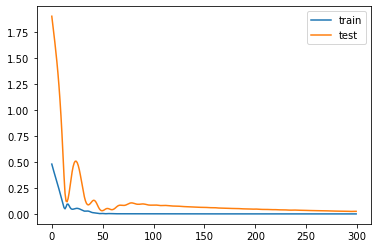

In [11]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()